In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

# --- Hyperparameters ---
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = '/home/anhkhoa/ml4secu/save_path'
datapath = '/home/anhkhoa/ml4secu/data.csv'

# --- Load Dataset ---
train_dataset = simDataset(datapath=datapath, device=device, split='train')
test_dataset = simDataset(datapath=datapath, device=device, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# FGSM Attack

In [17]:
import numpy as np

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model = load_model(model, os.path.join(save_path, f'{model.model_name}.pth'))
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()


# --- Khởi tạo Solver ---
solver = Solver(args)
criterion = nn.CrossEntropyLoss()

accuracy_list = []
accuracy_before_defense_adv_list = []

for epsilon in np.arange(0, 2.05, 0.05):
    accuracy, accuracy_adv = solver.generate(
        num_sample=100,
        target=None,
        epsilon=epsilon,
        alpha=0.03,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_before_defense_adv_list.append(accuracy_adv)




Model loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM.pth
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: []
[BEFORE] accuracy : 0.92 cost : 0.170
[AFTER]  accuracy : 0.92 cost : 0.170
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 16, 17, 20, 21, 24, 25, 29, 30, 33, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 51, 53, 55, 56, 57, 58, 59, 61, 64, 65, 66, 71, 72, 73, 74, 75, 76, 81, 83, 85, 86, 94, 95, 96]
[BEFORE] accuracy : 0.92 cost : 0.170
[AFTER]  accuracy : 0.38 cost : 3.191
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19, 20, 21, 24, 25, 28, 29, 30, 33, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 5

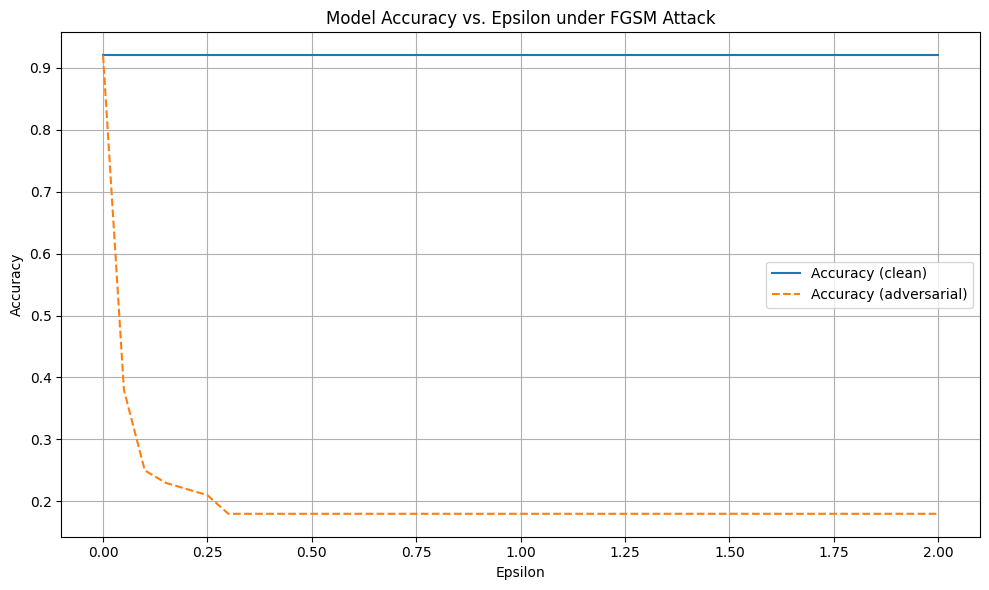

In [19]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 2.05, 0.05))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_list, label='Accuracy (clean)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy (adversarial)', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Adversarial Training - FGSM Defense

In [11]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

model = LSTM().to(device)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))

# --- Gói các tham số vào args giả lập ---
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()

# --- Khởi tạo Solver ---
solver = Solver(args)

solver.adv_train(train_loader=train_loader, val_loader=test_loader, num_epochs=num_epochs, alpha = 0.01, eps = 0.1)

[AdvTrain] Epoch 1/10:   0%|          | 0/411 [00:00<?, ?batch/s]

[AdvTrain] Epoch 1/10: 100%|██████████| 411/411 [00:06<00:00, 60.76batch/s, adv_loss=0.623]


[AdvTrain] Epoch 1 - Avg Loss: 0.6230


[AdvTrain] Epoch 2/10: 100%|██████████| 411/411 [00:04<00:00, 86.79batch/s, adv_loss=0.609]  


[AdvTrain] Epoch 2 - Avg Loss: 0.6086


[AdvTrain] Epoch 3/10: 100%|██████████| 411/411 [00:07<00:00, 55.40batch/s, adv_loss=0.601]


[AdvTrain] Epoch 3 - Avg Loss: 0.6008


[AdvTrain] Epoch 4/10: 100%|██████████| 411/411 [00:07<00:00, 56.41batch/s, adv_loss=0.507]


[AdvTrain] Epoch 4 - Avg Loss: 0.5070


[AdvTrain] Epoch 5/10: 100%|██████████| 411/411 [00:06<00:00, 61.74batch/s, adv_loss=0.4]  


[AdvTrain] Epoch 5 - Avg Loss: 0.4004


[AdvTrain] Epoch 6/10: 100%|██████████| 411/411 [00:04<00:00, 91.60batch/s, adv_loss=0.376]


[AdvTrain] Epoch 6 - Avg Loss: 0.3762


[AdvTrain] Epoch 7/10: 100%|██████████| 411/411 [00:06<00:00, 60.45batch/s, adv_loss=0.371]


[AdvTrain] Epoch 7 - Avg Loss: 0.3706


[AdvTrain] Epoch 8/10: 100%|██████████| 411/411 [00:07<00:00, 56.86batch/s, adv_loss=0.36] 


[AdvTrain] Epoch 8 - Avg Loss: 0.3601


[AdvTrain] Epoch 9/10: 100%|██████████| 411/411 [00:06<00:00, 66.65batch/s, adv_loss=0.362]


[AdvTrain] Epoch 9 - Avg Loss: 0.3617


[AdvTrain] Epoch 10/10: 100%|██████████| 411/411 [00:06<00:00, 66.01batch/s, adv_loss=0.357]


[AdvTrain] Epoch 10 - Avg Loss: 0.3570


Evaluating: 100%|██████████| 3286/3286 [00:08<00:00, 388.49batch/s, acc=81.89%] 


Saving model


In [16]:
model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))
solver.model = model

accuracy_list = []
accuracy_after_defense_adv_list = []
import numpy as np
for epsilon in np.arange(0, 2.05, 0.05):
    accuracy, accuracy_adv = solver.generate(
        num_sample=100,
        target=None,
        epsilon=epsilon,
        alpha=0.01,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_after_defense_adv_list.append(accuracy_adv)

Model loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_adv.pth
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: []
[BEFORE] accuracy : 0.81 cost : 0.333
[AFTER]  accuracy : 0.81 cost : 0.333
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: [15, 36, 41, 57]
[BEFORE] accuracy : 0.81 cost : 0.333
[AFTER]  accuracy : 0.77 cost : 0.375
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: [15, 36, 41, 57, 83, 94]
[BEFORE] accuracy : 0.81 cost : 0.333
[AFTER]  accuracy : 0.75 cost : 0.585
x_true shape: torch.Size([100, 7]), y_true shape: torch.Size([100])
Generate attack on batch size: 100
Changed Predictions Indexes: [15, 36, 41, 57, 83, 94]
[BEFORE] accuracy : 0.81 cost : 0.333
[AFTER]  accuracy : 0.75 cost : 0.585
x_true shape: torch.Si

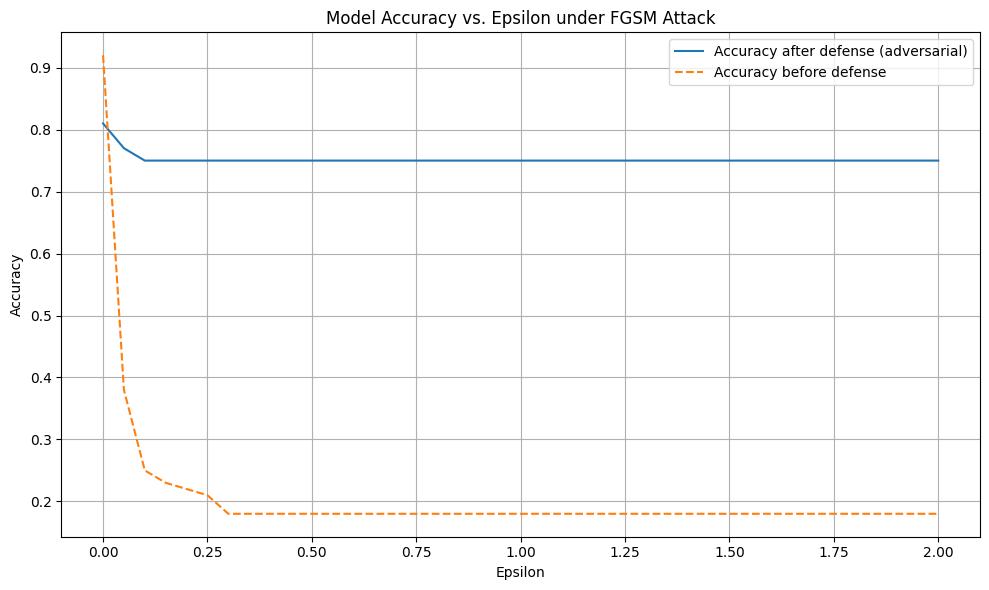

In [18]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 2.05, 0.05))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_after_defense_adv_list, label='Accuracy after defense (adversarial)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy before defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Label Flipping poisoning Attack